# Automotive Forum Post Processing - Proof of Concept

This notebook demonstrates a complete benchmark comparison of different model approaches for automotive forum post processing, using Google's Gemini models as free alternatives to demonstrate the framework.

## Model Mapping for POC:
- **Gemini Pro** → Large Decoder (GPT-4 equivalent)
- **Gemini Flash** → Small Decoder (GPT-3.5-turbo equivalent)

We'll test on 10 carefully selected examples covering all topics and suspicious score ranges to demonstrate the complete benchmark pipeline.

## 1. Package Installation and Setup

In [74]:
# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn google-generativeai python-dotenv tabulate


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
import json
import os
from dotenv import load_dotenv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any
from dataclasses import dataclass
from enum import Enum
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_absolute_error
import google.generativeai as genai
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All imports successful!")
print("Note: You'll need to set your GOOGLE_API_KEY in .env file")
print("Get your free API key from: https://makersuite.google.com/app/apikey")

# Load variables from .env file
load_dotenv()
# Get your API key
api_key = os.getenv("GOOGLE_API_KEY")

All imports successful!
Note: You'll need to set your GOOGLE_API_KEY in .env file
Get your free API key from: https://makersuite.google.com/app/apikey


In [76]:
## Config

# Configure generation parameters
generation_config = {
    "temperature": 0.1,  # Low temperature for consistency
    "top_p": 0.9,
    "top_k": 40,
    "max_output_tokens": 2048,
}

llm_judge_generation_config = {
        "temperature": 0.3,  # Balanced - allow some reasoning flexibility
        "top_p": 0.95,
        "max_output_tokens": 4096,
    }

## 2. Imports and Setup

In [77]:
class Topic(Enum):
    ODOMETER = "odometer"
    KEY_PROGRAMMING = "key programming"
    SERVICE_ACTIVATION = "service activation"
    IMMOBILIZER = "immobilizer"
    ENGINE_TUNING = "engine tuning"

@dataclass
class ForumPost:
    """Input forum post structure"""
    id: str
    title: str
    content: str
    author: str
    timestamp: str
    forum_section: str

@dataclass
class ProcessingResult:
    """Model output structure"""
    summary: str
    keywords: List[str]
    topic: str
    suspicious_score: int
    processing_time_ms: float
    raw_response: str = ""

@dataclass
class GroundTruth:
    """Ground truth labels"""
    summary: str
    keywords: List[str]
    topic: str
    suspicious_score: int

print("Data structures defined successfully!")

Data structures defined successfully!


## 3. Load Dataset and Select Test Cases

In [78]:
# Load the complete dataset
with open('automotive_forum_dataset.json', 'r') as f:
    dataset = json.load(f)

print(f"Loaded dataset with {len(dataset['posts'])} posts")
print(f"Topics: {dataset['metadata']['topics']}")
print(f"Suspicious score distribution: {dataset['metadata']['suspicious_score_distribution']}")

# Split dataset for POC: 80% train, 10% validation, 10% test
# With stratification to maintain topic and suspicious score balance
import random
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Calculate target sizes
total_posts = len(dataset['posts'])
target_test = int(0.1 * total_posts)      # 10 posts
target_val = int(0.1 * total_posts)       # 10 posts
target_train = total_posts - target_test - target_val  # 80 posts

print(f"\nTarget split: {target_train} train, {target_val} val, {target_test} test")

# Simple stratified split: shuffle all posts and take proportional samples
# This maintains overall balance while hitting target percentages
all_posts = dataset['posts'].copy()
random.shuffle(all_posts)

# Split by simple percentage to hit targets exactly
test_posts = all_posts[:target_test]
validation_posts = all_posts[target_test:target_test + target_val]
train_posts = all_posts[target_test + target_val:]

print(f"\nDataset split:")
print(f"  Training: {len(train_posts)} posts ({len(train_posts)/total_posts:.1%})")
print(f"  Validation: {len(validation_posts)} posts ({len(validation_posts)/total_posts:.1%})")
print(f"  Test: {len(test_posts)} posts ({len(test_posts)/total_posts:.1%})")

# Use test set for evaluation (exactly 10% of data = 10 posts)
selected_posts = test_posts
print(f"\nUsing test set with {len(selected_posts)} posts for evaluation")

# Create ForumPost and GroundTruth objects for test set
test_forum_posts = []
ground_truths = []

for post in selected_posts:
    # Create ForumPost object
    forum_post = ForumPost(
        id=post['id'],
        title=post['title'],
        content=post['content'],
        author=post['author'],
        timestamp=post['timestamp'],
        forum_section=post['forum_section']
    )
    test_forum_posts.append(forum_post)
    
    # Create GroundTruth object
    gt = post['ground_truth']
    ground_truth = GroundTruth(
        summary=gt['summary'],
        keywords=gt['keywords'],
        topic=gt['topic'],
        suspicious_score=gt['suspicious_score']
    )
    ground_truths.append(ground_truth)

# Verify topic and suspicious score distribution in test set
test_topic_dist = defaultdict(int)
test_suspicious_dist = defaultdict(int)

for gt in ground_truths:
    test_topic_dist[gt.topic] += 1
    test_suspicious_dist[gt.suspicious_score] += 1

print(f"\nTest set distribution:")
print(f"  Topics: {dict(test_topic_dist)}")
print(f"  Suspicious scores: {dict(test_suspicious_dist)}")

# Show test post IDs to ensure no overlap with system prompt examples
test_post_ids = [post['id'] for post in selected_posts]
print(f"\nTest post IDs: {test_post_ids}")

# Update variable name for consistency with rest of notebook
test_posts = test_forum_posts

print(f"\nTest set prepared with {len(test_posts)} posts (exactly 10%)")
print("System prompt examples will use training data to avoid data leakage")

Loaded dataset with 100 posts
Topics: ['odometer', 'key programming', 'service activation', 'immobilizer', 'engine tuning']
Suspicious score distribution: {'1': 40, '2': 20, '3': 20, '4': 15, '5': 5}

Target split: 80 train, 10 val, 10 test

Dataset split:
  Training: 80 posts (80.0%)
  Validation: 10 posts (10.0%)
  Test: 10 posts (10.0%)

Using test set with 10 posts for evaluation

Test set distribution:
  Topics: {'immobilizer': 3, 'odometer': 3, 'key programming': 2, 'service activation': 2}
  Suspicious scores: {2: 4, 5: 2, 1: 4}

Test post IDs: ['post_043', 'post_042', 'post_092', 'post_010', 'post_066', 'post_051', 'post_002', 'post_071', 'post_016', 'post_079']

Test set prepared with 10 posts (exactly 10%)
System prompt examples will use training data to avoid data leakage


## 4. Gemini Model Implementation

In [79]:
class GeminiProcessor:
    """Base class for Gemini-based processors with improved JSON parsing and generation config"""
    
    def __init__(self, model_name: str, system_prompt: str, api_key: str = None):
        if api_key is None:
            api_key = os.getenv('GOOGLE_API_KEY')
            if not api_key:
                raise ValueError("Please set GOOGLE_API_KEY environment variable")
        
        genai.configure(api_key=api_key)
        
        self.model = genai.GenerativeModel(model_name, generation_config=generation_config)
        self.system_prompt = system_prompt
        self.model_name = model_name
    
    def process(self, post: ForumPost) -> ProcessingResult:
        """Process a forum post and return structured results"""
        start_time = time.time()
        
        # Construct the full prompt
        full_prompt = f"{self.system_prompt}\n\n{post.content}"
        
        try:
            # Generate response
            response = self.model.generate_content(full_prompt)
            response_text = response.text
            
            # Improved JSON extraction - handle markdown code blocks
            json_str = None
            
            # Try extracting from ```json code block
            if "```json" in response_text:
                json_str = response_text.split("```json")[1].split("```")[0].strip()
            # Try extracting from ``` code block
            elif "```" in response_text:
                json_str = response_text.split("```")[1].split("```")[0].strip()
            # Try finding raw JSON object
            else:
                json_start = response_text.find('{')
                json_end = response_text.rfind('}') + 1
                
                if json_start != -1 and json_end > 0:
                    json_str = response_text[json_start:json_end]
            
            if not json_str:
                raise ValueError("No JSON found in response")
            
            # Parse JSON
            result_data = json.loads(json_str)
            
            # Validate required fields
            required_fields = ['summary', 'keywords', 'topic', 'suspicious_score']
            missing = [f for f in required_fields if f not in result_data]
            if missing:
                raise ValueError(f"Missing required fields: {missing}")
            
            # Validate topic is in allowed list
            valid_topics = ['odometer', 'key programming', 'service activation', 'immobilizer', 'engine tuning']
            if result_data['topic'] not in valid_topics:
                print(f"⚠️  Warning: Invalid topic '{result_data['topic']}', defaulting to 'odometer'")
                result_data['topic'] = 'odometer'
            
            # Ensure suspicious_score is int and in range
            sus_score = int(result_data['suspicious_score'])
            if not (1 <= sus_score <= 5):
                print(f"⚠️  Warning: Suspicious score {sus_score} out of range, clamping to 1-5")
                sus_score = max(1, min(5, sus_score))
            
            processing_time = (time.time() - start_time) * 1000
            
            return ProcessingResult(
                summary=result_data.get('summary', ''),
                keywords=result_data.get('keywords', []),
                topic=result_data['topic'],
                suspicious_score=sus_score,
                processing_time_ms=processing_time,
                raw_response=response_text
            )
            
        except Exception as e:
            print(f"❌ Error processing with {self.model_name}: {str(e)}")
            processing_time = (time.time() - start_time) * 1000
            
            # Return default result on error
            return ProcessingResult(
                summary="Error processing post",
                keywords=[],
                topic="odometer",  # Default topic
                suspicious_score=1,
                processing_time_ms=processing_time,
                raw_response=str(e)
            )

In [80]:
print("System prompt will be loaded from prompts/gemini_system_prompts.md file")
# Load unified system prompt from markdown file
with open('prompts/gemini_system_prompts.md', 'r') as f:
    unified_system_prompt = f.read()

# Initialize processors with the SAME unified system prompt
try:
    # Fixed: Use correct Gemini model names with -latest suffix
    gemini_pro = GeminiProcessor("gemini-pro-latest", unified_system_prompt)
    gemini_flash = GeminiProcessor("gemini-flash-latest", unified_system_prompt)
    
    processors = {
        "Gemini Pro (Large Decoder)": gemini_pro,
        "Gemini Flash (Small Decoder)": gemini_flash
    }
    
    print(f"\nReady to benchmark {len(processors)} models on {len(test_posts)} test cases")
    
except NameError as e:
    print(f"Variable not defined: {e}")
    print("Make sure to run previous cells first to define unified_system_prompt and test_posts")
    raise
except Exception as e:
    print(f"Error initializing models: {e}")
    print("Make sure to set your GOOGLE_API_KEY environment variable")
    print("Get your free API key from: https://makersuite.google.com/app/apikey")
    raise

System prompt will be loaded from prompts/gemini_system_prompts.md file

Ready to benchmark 2 models on 10 test cases


In [81]:
# # Run benchmark on all test cases
# results = {}
#
# for model_name, processor in processors.items():
#     print(f"\nTesting {model_name}...")
#     model_results = []
#
#     for i, post in enumerate(test_posts):
#         print(f"  Processing post {i+1}/{len(test_posts)}: {post.id}")
#
#         try:
#             result = processor.process(post)
#             model_results.append(result)
#             print(f"    Topic: {result.topic}, Suspicious: {result.suspicious_score}, Time: {result.processing_time_ms:.1f}ms")
#
#             # Small delay to avoid rate limiting
#             time.sleep(1)
#
#         except Exception as e:
#             print(f"    Error: {e}")
#             # Create default result
#             default_result = ProcessingResult(
#                 summary="Error processing",
#                 keywords=[],
#                 topic="odometer",
#                 suspicious_score=1,
#                 processing_time_ms=0,
#                 raw_response=str(e)
#             )
#             model_results.append(default_result)
#
#     results[model_name] = model_results
#     print(f"Completed {model_name}")
#
# print("\nBenchmark completed!")

## 5. rate-limiting queue system
Gemini Pro has a limit of 3 requests per minute on the free tier
Gemini Flash has a limit of 10 requests per minute on the free tier

In [82]:
import re
from datetime import datetime, timedelta

results = {}

def extract_retry_delay(error_message):
    """Extract retry delay in seconds from error message"""
    match = re.search(r'retry in ([\d.]+)s', str(error_message))
    if match:
        return float(match.group(1))
    return None

def process_with_rate_limit(processor, posts, model_name, requests_per_minute=2):
    """Process posts with rate limiting - respects API quotas"""
    model_results = []
    request_times = []

    print(f"\nTesting {model_name}...")
    print(f"Rate limit: {requests_per_minute} requests/minute")

    for i, post in enumerate(posts):
        print(f"  Processing post {i+1}/{len(posts)}: {post.id}")

        # Rate limiting logic
        now = datetime.now()
        # Remove timestamps older than 60 seconds
        request_times = [t for t in request_times if now - t < timedelta(seconds=60)]

        # If we've hit the limit, wait until oldest request expires
        if len(request_times) >= requests_per_minute:
            wait_time = 60 - (now - request_times[0]).total_seconds() + 1
            if wait_time > 0:
                print(f"  Rate limit reached. Waiting {wait_time:.1f}s...")
                time.sleep(wait_time)
                # Clear old timestamps after waiting
                request_times = []

        # Try processing with retry logic
        max_retries = 3
        for attempt in range(max_retries):
            try:
                result = processor.process(post)
                request_times.append(datetime.now())
                model_results.append(result)
                print(f"    Topic: {result.topic}, Suspicious: {result.suspicious_score}, Time: {result.processing_time_ms:.1f}ms")
                break  # Success, exit retry loop

            except Exception as e:
                error_str = str(e)

                # Check if it's a rate limit error (429)
                if "429" in error_str or "quota" in error_str.lower():
                    retry_delay = extract_retry_delay(error_str)

                    if retry_delay and attempt < max_retries - 1:
                        print(f"    Rate limited. Waiting {retry_delay:.1f}s before retry {attempt + 1}/{max_retries}...")
                        time.sleep(retry_delay + 1)  # Add 1 second buffer
                        continue
                    else:
                        print(f"    Rate limit error (attempt {attempt + 1}/{max_retries})")
                else:
                    print(f"    Error: {error_str[:100]}...")

                # If we've exhausted retries or it's not a rate limit error
                if attempt == max_retries - 1:
                    default_result = ProcessingResult(
                        summary="Error processing",
                        keywords=[],
                        topic="odometer",
                        suspicious_score=1,
                        processing_time_ms=0,
                        raw_response=error_str
                    )
                    model_results.append(default_result)
                    break

    print(f"Completed {model_name}")
    return model_results

# Process each model with appropriate rate limits
# Gemini Pro: 2 requests/minute (strict)
# Gemini Flash: 15 requests/minute (more lenient)
for model_name, processor in processors.items():
    if "Pro" in model_name:
        rate_limit = 3  # Gemini Pro free tier
    else:
        rate_limit = 10  # Gemini Flash free tier

    results[model_name] = process_with_rate_limit(
        processor,
        test_posts,
        model_name,
        requests_per_minute=rate_limit
    )

print("\nBenchmark completed!")


Testing Gemini Pro (Large Decoder)...
Rate limit: 3 requests/minute
  Processing post 1/10: post_043
    Topic: immobilizer, Suspicious: 2, Time: 12685.7ms
  Processing post 2/10: post_042
    Topic: immobilizer, Suspicious: 5, Time: 10347.3ms
  Processing post 3/10: post_092
    Topic: odometer, Suspicious: 1, Time: 12086.7ms
  Processing post 4/10: post_010
  Rate limit reached. Waiting 38.6s...
    Topic: key programming, Suspicious: 1, Time: 7082.2ms
  Processing post 5/10: post_066
    Topic: odometer, Suspicious: 1, Time: 12595.2ms
  Processing post 6/10: post_051
    Topic: service activation, Suspicious: 1, Time: 18123.6ms
  Processing post 7/10: post_002
  Rate limit reached. Waiting 30.3s...
    Topic: odometer, Suspicious: 5, Time: 11384.6ms
  Processing post 8/10: post_071
    Topic: key programming, Suspicious: 1, Time: 14232.2ms
  Processing post 9/10: post_016
    Topic: immobilizer, Suspicious: 2, Time: 23286.7ms
  Processing post 10/10: post_079
  Rate limit reached. 

In [83]:
def calculate_keyword_metrics(predicted_keywords: List[str], true_keywords: List[str]) -> Dict[str, float]:
    """Calculate precision, recall, and Jaccard similarity for keywords"""
    if not predicted_keywords and not true_keywords:
        return {"precision": 1.0, "recall": 1.0, "jaccard": 1.0}
    
    pred_set = set([kw.lower() for kw in predicted_keywords])
    true_set = set([kw.lower() for kw in true_keywords])
    
    intersection = len(pred_set & true_set)
    union = len(pred_set | true_set)
    
    precision = intersection / len(pred_set) if pred_set else 0.0
    recall = intersection / len(true_set) if true_set else 0.0
    jaccard = intersection / union if union > 0 else 0.0
    
    return {
        "precision": precision,
        "recall": recall,
        "jaccard": jaccard
    }

def evaluate_model_performance(predictions: List[ProcessingResult], ground_truths: List[GroundTruth]) -> Dict[str, Any]:
    """Comprehensive evaluation of model performance"""
    
    # Topic Classification Metrics
    pred_topics = [p.topic for p in predictions]
    true_topics = [gt.topic for gt in ground_truths]
    
    topic_accuracy = accuracy_score(true_topics, pred_topics)
    topic_precision, topic_recall, topic_f1, _ = precision_recall_fscore_support(
        true_topics, pred_topics, average='macro', zero_division=0
    )
    
    # Suspicious Score Metrics
    pred_suspicious = [p.suspicious_score for p in predictions]
    true_suspicious = [gt.suspicious_score for gt in ground_truths]
    
    suspicious_accuracy = accuracy_score(true_suspicious, pred_suspicious)
    suspicious_mae = mean_absolute_error(true_suspicious, pred_suspicious)
    
    # Convert to binary (high risk ≥ 4 vs low risk ≤ 3) for additional metrics
    true_binary = [1 if score >= 4 else 0 for score in true_suspicious]
    pred_binary = [1 if score >= 4 else 0 for score in pred_suspicious]
    
    binary_accuracy = accuracy_score(true_binary, pred_binary)
    
    # Keyword Metrics
    keyword_metrics = []
    for pred, gt in zip(predictions, ground_truths):
        kw_metrics = calculate_keyword_metrics(pred.keywords, gt.keywords)
        keyword_metrics.append(kw_metrics)
    
    avg_keyword_precision = np.mean([m['precision'] for m in keyword_metrics])
    avg_keyword_recall = np.mean([m['recall'] for m in keyword_metrics])
    avg_keyword_jaccard = np.mean([m['jaccard'] for m in keyword_metrics])
    
    # Performance Metrics
    avg_processing_time = np.mean([p.processing_time_ms for p in predictions])
    
    return {
        "topic_accuracy": topic_accuracy,
        "topic_precision": topic_precision,
        "topic_recall": topic_recall,
        "topic_f1": topic_f1,
        "suspicious_accuracy": suspicious_accuracy,
        "suspicious_mae": suspicious_mae,
        "suspicious_binary_accuracy": binary_accuracy,
        "keyword_precision": avg_keyword_precision,
        "keyword_recall": avg_keyword_recall,
        "keyword_jaccard": avg_keyword_jaccard,
        "avg_processing_time_ms": avg_processing_time,
        "confusion_matrix_topics": confusion_matrix(true_topics, pred_topics),
        "confusion_matrix_suspicious": confusion_matrix(true_suspicious, pred_suspicious)
    }

# Calculate metrics for each model
evaluation_results = {}

for model_name, predictions in results.items():
    metrics = evaluate_model_performance(predictions, ground_truths)
    evaluation_results[model_name] = metrics
    
    print(f"\n{model_name} Performance:")
    print(f"  Topic Accuracy: {metrics['topic_accuracy']:.3f}")
    print(f"  Topic F1-Score: {metrics['topic_f1']:.3f}")
    print(f"  Suspicious Score Accuracy: {metrics['suspicious_accuracy']:.3f}")
    print(f"  Suspicious Score MAE: {metrics['suspicious_mae']:.3f}")
    print(f"  Keyword Precision: {metrics['keyword_precision']:.3f}")
    print(f"  Keyword Recall: {metrics['keyword_recall']:.3f}")
    print(f"  Avg Processing Time: {metrics['avg_processing_time_ms']:.1f}ms")

print("\nEvaluation metrics calculated!")


Gemini Pro (Large Decoder) Performance:
  Topic Accuracy: 1.000
  Topic F1-Score: 1.000
  Suspicious Score Accuracy: 0.700
  Suspicious Score MAE: 0.300
  Keyword Precision: 0.443
  Keyword Recall: 0.593
  Avg Processing Time: 13628.4ms

Gemini Flash (Small Decoder) Performance:
  Topic Accuracy: 1.000
  Topic F1-Score: 1.000
  Suspicious Score Accuracy: 0.600
  Suspicious Score MAE: 0.400
  Keyword Precision: 0.449
  Keyword Recall: 0.560
  Avg Processing Time: 3685.8ms

Evaluation metrics calculated!


## 6. Results Visualization

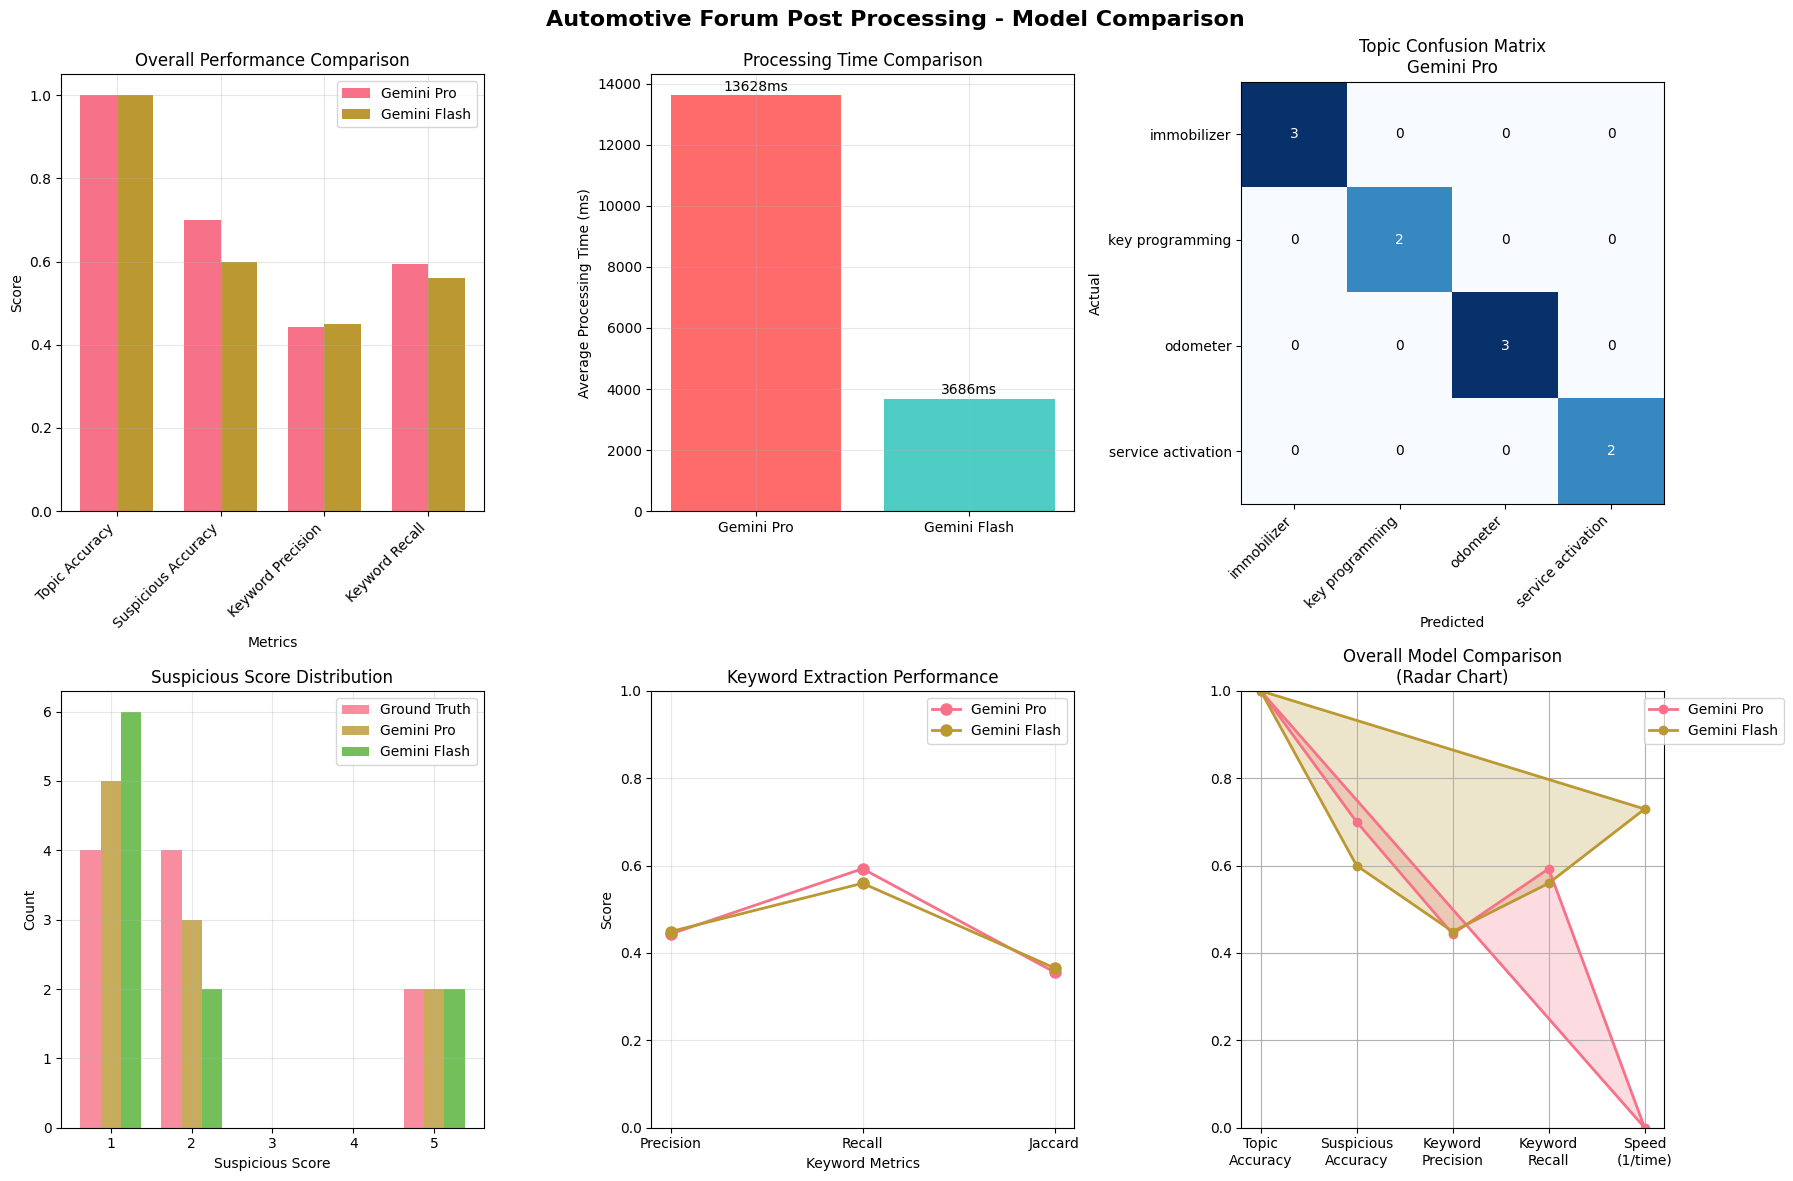

Comprehensive visualization completed!


In [84]:
# Create comprehensive results visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Automotive Forum Post Processing - Model Comparison', fontsize=16, fontweight='bold')

# 1. Overall Performance Comparison
ax1 = axes[0, 0]
models = list(evaluation_results.keys())
metrics_to_plot = ['topic_accuracy', 'suspicious_accuracy', 'keyword_precision', 'keyword_recall']
metric_labels = ['Topic Accuracy', 'Suspicious Accuracy', 'Keyword Precision', 'Keyword Recall']

x = np.arange(len(metric_labels))
width = 0.35

for i, model in enumerate(models):
    values = [evaluation_results[model][metric] for metric in metrics_to_plot]
    ax1.bar(x + i*width, values, width, label=model.split(' (')[0])

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Overall Performance Comparison')
ax1.set_xticks(x + width/2)
ax1.set_xticklabels(metric_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Processing Time Comparison
ax2 = axes[0, 1]
processing_times = [evaluation_results[model]['avg_processing_time_ms'] for model in models]
model_names_short = [model.split(' (')[0] for model in models]

bars = ax2.bar(model_names_short, processing_times, color=['#FF6B6B', '#4ECDC4'])
ax2.set_ylabel('Average Processing Time (ms)')
ax2.set_title('Processing Time Comparison')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, processing_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{time_val:.0f}ms', ha='center', va='bottom')

# 3. Topic Classification Confusion Matrix (Gemini Pro)
ax3 = axes[0, 2]
topic_names = ['odometer', 'key programming', 'service activation', 'immobilizer', 'engine tuning']
cm_topics = evaluation_results[models[0]]['confusion_matrix_topics']

# Create a properly sized confusion matrix
unique_topics = list(set([gt.topic for gt in ground_truths] + [p.topic for p in results[models[0]]]))
topic_map = {topic: i for i, topic in enumerate(sorted(unique_topics))}

im3 = ax3.imshow(cm_topics, interpolation='nearest', cmap='Blues')
ax3.set_title(f'Topic Confusion Matrix\n{models[0].split(" (")[0]}')
tick_marks = np.arange(len(unique_topics))
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3.set_xticklabels(sorted(unique_topics), rotation=45, ha='right')
ax3.set_yticklabels(sorted(unique_topics))
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Add text annotations
thresh = cm_topics.max() / 2.
for i in range(cm_topics.shape[0]):
    for j in range(cm_topics.shape[1]):
        ax3.text(j, i, format(cm_topics[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm_topics[i, j] > thresh else "black")

# 4. Suspicious Score Distribution
ax4 = axes[1, 0]
true_scores = [gt.suspicious_score for gt in ground_truths]
pred_scores_pro = [p.suspicious_score for p in results[models[0]]]
pred_scores_flash = [p.suspicious_score for p in results[models[1]]]

x_pos = np.arange(1, 6)
true_counts = [true_scores.count(i) for i in range(1, 6)]
pred_counts_pro = [pred_scores_pro.count(i) for i in range(1, 6)]
pred_counts_flash = [pred_scores_flash.count(i) for i in range(1, 6)]

width = 0.25
ax4.bar(x_pos - width, true_counts, width, label='Ground Truth', alpha=0.8)
ax4.bar(x_pos, pred_counts_pro, width, label='Gemini Pro', alpha=0.8)
ax4.bar(x_pos + width, pred_counts_flash, width, label='Gemini Flash', alpha=0.8)

ax4.set_xlabel('Suspicious Score')
ax4.set_ylabel('Count')
ax4.set_title('Suspicious Score Distribution')
ax4.set_xticks(x_pos)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Keyword Performance Detailed
ax5 = axes[1, 1]
keyword_metrics = ['keyword_precision', 'keyword_recall', 'keyword_jaccard']
keyword_labels = ['Precision', 'Recall', 'Jaccard']

x = np.arange(len(keyword_labels))
for i, model in enumerate(models):
    values = [evaluation_results[model][metric] for metric in keyword_metrics]
    ax5.plot(x, values, marker='o', linewidth=2, markersize=8, label=model.split(' (')[0])

ax5.set_xlabel('Keyword Metrics')
ax5.set_ylabel('Score')
ax5.set_title('Keyword Extraction Performance')
ax5.set_xticks(x)
ax5.set_xticklabels(keyword_labels)
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_ylim([0, 1])

# 6. Model Comparison Radar Chart
ax6 = axes[1, 2]
categories = ['Topic\nAccuracy', 'Suspicious\nAccuracy', 'Keyword\nPrecision', 'Keyword\nRecall', 'Speed\n(1/time)']

# Normalize processing time to 0-1 scale (higher is better)
max_time = max([evaluation_results[model]['avg_processing_time_ms'] for model in models])

for model in models:
    metrics = evaluation_results[model]
    values = [
        metrics['topic_accuracy'],
        metrics['suspicious_accuracy'],
        metrics['keyword_precision'],
        metrics['keyword_recall'],
        1 - (metrics['avg_processing_time_ms'] / max_time)  # Invert time (higher = faster)
    ]
    
    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    values += values[:1]  # Complete the circle
    angles += angles[:1]
    
    ax6.plot(angles, values, 'o-', linewidth=2, label=model.split(' (')[0])
    ax6.fill(angles, values, alpha=0.25)

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim([0, 1])
ax6.set_title('Overall Model Comparison\n(Radar Chart)')
ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax6.grid(True)

plt.tight_layout()
plt.show()

print("Comprehensive visualization completed!")

## 7. Sample Outputs Inspection

In [85]:
# Display sample outputs for manual inspection
print("🔍 Sample Model Outputs for Manual Inspection")
print("=" * 80)

# Show first 3 test cases with model outputs
for i in range(min(3, len(test_posts))):
    post = test_posts[i]
    gt = ground_truths[i]
    
    print(f"\nPOST {i+1}: {post.id}")
    print(f"Title: {post.title}")
    print(f"Content: {post.content[:200]}{'...' if len(post.content) > 200 else ''}")
    
    print(f"\nGROUND TRUTH:")
    print(f"  Topic: {gt.topic}")
    print(f"  Suspicious Score: {gt.suspicious_score}")
    print(f"  Keywords: {gt.keywords}")
    print(f"  Summary: {gt.summary}")
    
    for model_name, predictions in results.items():
        pred = predictions[i]
        print(f"\n{model_name.upper()}:")
        print(f"  Topic: {pred.topic} {'✅' if pred.topic == gt.topic else '❌'}")
        print(f"  Suspicious Score: {pred.suspicious_score} {'✅' if pred.suspicious_score == gt.suspicious_score else '❌'}")
        print(f"  Keywords: {pred.keywords}")
        print(f"  Summary: {pred.summary}")
        print(f"  Processing Time: {pred.processing_time_ms:.1f}ms")
    
    print("\n" + "-" * 80)

print("\nSample inspection completed!")

🔍 Sample Model Outputs for Manual Inspection

POST 1: post_043
Title: Immobilizer reset after ECU reflash
Content: I had my 2018 Volkswagen GTI ECU reflashed with a Stage 1 tune and now the immobilizer isn't working properly. The car starts but sometimes shows immobilizer warning messages on the dash. The tuning s...

GROUND TRUTH:
  Topic: immobilizer
  Suspicious Score: 2
  Keywords: ['immobilizer reset', 'ECU reflash', 'Volkswagen GTI', 'Stage 1 tune', 'warning messages', 'relearned']
  Summary: GTI owner experiencing immobilizer warnings after ECU tune, seeking reset procedure to resolve warning messages.

GEMINI PRO (LARGE DECODER):
  Topic: immobilizer ✅
  Suspicious Score: 2 ✅
  Keywords: ['Volkswagen GTI', 'ECU reflashed', 'Stage 1 tune', 'immobilizer', 'immobilizer warning', 'ECU modifications', 'immobilizer reset', 'relearned', 'ECU tuning']
  Summary: User's 2018 VW GTI is showing immobilizer warnings after a Stage 1 ECU tune. They are asking for the correct procedure to res

## 8. Detailed Results Analysis

In [86]:
# Create detailed results table
results_df = pd.DataFrame()

for i, (post, gt) in enumerate(zip(test_posts, ground_truths)):
    row = {
        'Post_ID': post.id,
        'True_Topic': gt.topic,
        'True_Suspicious': gt.suspicious_score,
        'True_Keywords_Count': len(gt.keywords)
    }

    for model_name, predictions in results.items():
        pred = predictions[i]
        model_short = model_name.split(' (')[0].replace(' ', '_')

        row[f'{model_short}_Topic'] = pred.topic
        row[f'{model_short}_Suspicious'] = pred.suspicious_score
        row[f'{model_short}_Keywords_Count'] = len(pred.keywords)
        row[f'{model_short}_Time_ms'] = pred.processing_time_ms

        # Calculate keyword overlap
        kw_metrics = calculate_keyword_metrics(pred.keywords, gt.keywords)
        row[f'{model_short}_Keyword_Jaccard'] = kw_metrics['jaccard']

    results_df = pd.concat([results_df, pd.DataFrame([row])], ignore_index=True)

print("Detailed Results Table:")
print("=" * 100)
display(results_df)

# Summary statistics - EXPANDED to include all relevant metrics
print("\nSummary Statistics:")
print("=" * 50)

summary_stats = pd.DataFrame(evaluation_results).T
summary_stats = summary_stats[[
    'topic_accuracy', 
    'topic_f1', 
    'suspicious_accuracy', 
    'suspicious_mae',
    'keyword_precision',
    'keyword_recall', 
    'keyword_jaccard',
    'avg_processing_time_ms'
]]
summary_stats.columns = [
    'Topic Accuracy', 
    'Topic F1', 
    'Suspicious Accuracy', 
    'Suspicious MAE',
    'Keyword Precision', 
    'Keyword Recall',
    'Keyword Jaccard',
    'Avg Time (ms)'
]
summary_stats = summary_stats.round(3)

display(summary_stats)
print("\nNote: Lower MAE is better, higher values are better for all other metrics")

Detailed Results Table:


,Post_ID,True_Topic,True_Suspicious,True_Keywords_Count,Gemini_Pro_Topic,Gemini_Pro_Suspicious,Gemini_Pro_Keywords_Count,Gemini_Pro_Time_ms,Gemini_Pro_Keyword_Jaccard,Gemini_Flash_Topic,Gemini_Flash_Suspicious,Gemini_Flash_Keywords_Count,Gemini_Flash_Time_ms,Gemini_Flash_Keyword_Jaccard
0,post_043,immobilizer,2,6,immobilizer,2,9,12685.745478,0.363636,immobilizer,1,8,4199.154854,0.272727
1,post_042,immobilizer,5,7,immobilizer,5,9,10347.321510,0.066667,immobilizer,5,8,3379.684925,0.071429
2,post_092,odometer,2,6,odometer,1,9,12086.681366,0.250000,odometer,1,7,3664.520264,0.300000
3,post_010,key programming,1,6,key programming,1,7,7082.226992,0.300000,key programming,1,8,2887.811422,0.400000
4,post_066,odometer,2,6,odometer,1,8,12595.204592,0.400000,odometer,1,8,4506.411552,0.166667
5,post_051,service activation,1,7,service activation,1,10,18123.568773,0.416667,service activation,1,8,4197.400808,0.250000
6,post_002,odometer,5,6,odometer,5,7,11384.569407,0.625000,odometer,5,8,2928.959846,0.750000
7,post_071,key programming,1,6,key programming,1,9,14232.160330,0.250000,key programming,1,9,3618.775606,0.153846
8,post_016,immobilizer,2,7,immobilizer,2,9,23286.749601,0.333333,immobilizer,2,8,4199.359894,0.666667
9,post_079,service activation,1,6,service activation,2,8,14459.321260,0.555556,service activation,2,7,3276.257515,0.625000



Summary Statistics:


,Topic Accuracy,Topic F1,Suspicious Accuracy,Suspicious MAE,Keyword Precision,Keyword Recall,Keyword Jaccard,Avg Time (ms)
Gemini Pro (Large Decoder),1.0,1.0,0.7,0.3,0.443452,0.592857,0.356086,13628.354931
Gemini Flash (Small Decoder),1.0,1.0,0.6,0.4,0.449008,0.559524,0.365634,3685.833669



Note: Lower MAE is better, higher values are better for all other metrics


## 9. LLM-as-a-Judge: Model Recommendation Analysis

Using an LLM to analyze the benchmark results and provide an expert recommendation on which model to use for production deployment.

In [88]:
# Load LLM judge system prompt with benchmark template
with open('prompts/llm_judge_system_prompt.md', 'r') as f:
    judge_prompt_template = f.read()

# Prepare data for template
judge_prompt = judge_prompt_template.format(
    total_samples=len(test_posts),
    topic_distribution=dict(test_topic_dist),
    suspicious_distribution=dict(test_suspicious_dist),
    summary_table=summary_stats.to_markdown()
)

# Initialize LLM judge using Gemini Flash
print("🤖 Initializing LLM Judge (Gemini Flash)...")
judge_llm = genai.GenerativeModel(
    "gemini-flash-latest",
    generation_config=llm_judge_generation_config
)

# Get judge's recommendation
print("Analyzing benchmark results...\n")

try:
    response = judge_llm.generate_content(judge_prompt)
    judge_recommendation = response.text
    
    print("=" * 100)
    print("🎯 LLM JUDGE EXPERT RECOMMENDATION")
    print("=" * 100)
    print()
    print(judge_recommendation)
    print()
    print("=" * 100)
    
except Exception as e:
    print(f"Error getting judge recommendation: {e}")
    judge_recommendation = "Error: Unable to generate recommendation"

🤖 Initializing LLM Judge (Gemini Flash)...
Analyzing benchmark results...

🎯 LLM JUDGE EXPERT RECOMMENDATION

## Expert AI/ML Deployment Analysis and Recommendation

### 1. Executive Summary

The recommended model for production deployment is **Gemini Flash (Small Decoder)**. While Gemini Pro offers marginally superior accuracy on the critical Suspicious Content Scoring task (70% vs 60%), its processing latency of **13.6 seconds** is unacceptable for a real-time, high-volume system. Gemini Flash provides a 3.7x speed improvement (3.7 seconds) with only a minor drop in overall quality, making it significantly more cost-effective and scalable. We recommend a **hybrid strategy** to mitigate the risk associated with the lower suspicious content accuracy.

---

### 2. Performance Comparison by Task

#### Topic Classification Analysis (Routing & Filtering)
| Model | Topic Accuracy | Topic F1 |
| :--- | :--- | :--- |
| Gemini Pro | 1.0 | 1.0 |
| Gemini Flash | 1.0 | 1.0 |
**Analysis:** Both m